Files:

- `Sub180221.py`: copied tensor calculation module
- `main.ipynb`: report note
- `flux.py`: multi-targeted DMRG solving flux
- `effective_flux.py`: solving effective single mode using exact diagonalization for benchmark
- `test_traditional.ipynb`: traditional method(adding a penalty term to the Hamiltonian) for excitations for benchmark

In [4]:
%matplotlib inline

# Solving fluxonium qubit using Multi-targeted DMRG

## Introduction

Calculate energy spectrum of fluxonium qubits in Ref.1, circuit as Fig.1

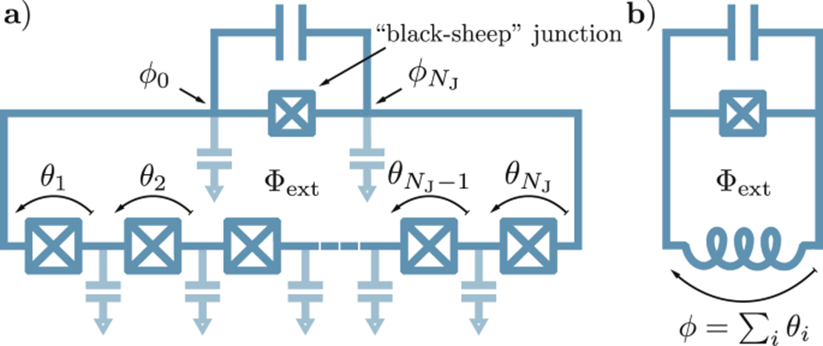

Fig.1 of Ref.1 Circuit model of the fluxonium qubit.

a) Detailed circuit scheme including a “black-sheep” junction (center) shunted by a capacitance (top) and a junction-array superinductance with NJ junctions (bottom). 

b) Effective circuit in which the junction array is modeled as a linear inductance.

Result of Ref.1

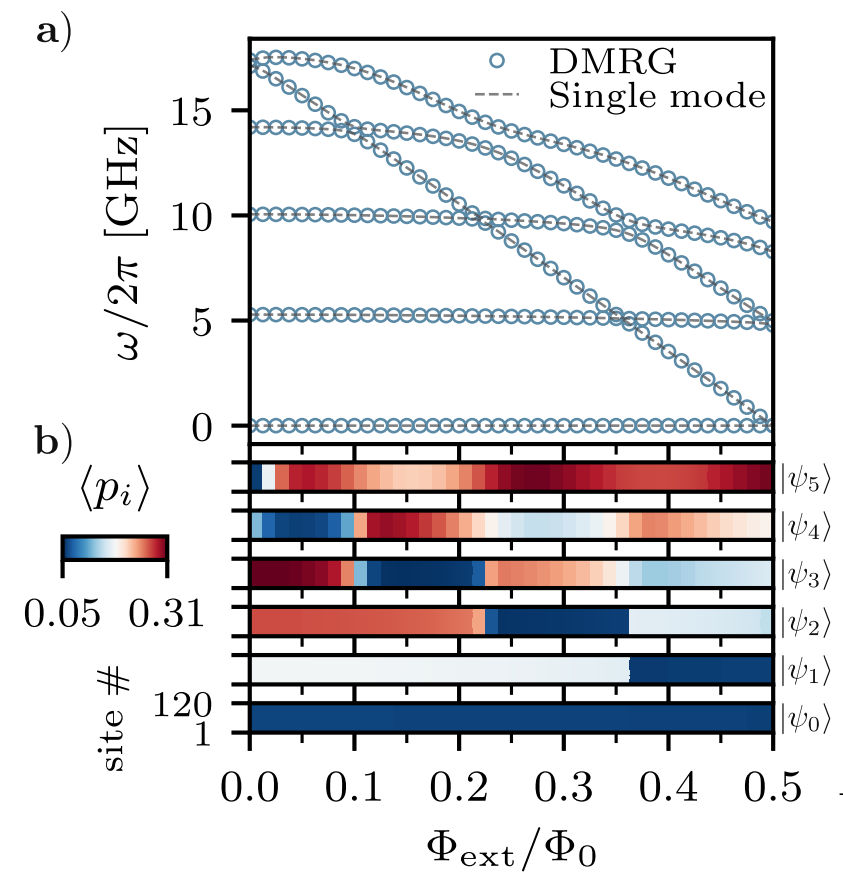

Fig.2 A 120-junction superinductance heavy fluxonium

energy spectrum of effective single mode and multi-targeted DMRG overlapped.

### MPO

Hamiltonian of a)

$$H=\sum\limits_{i=1}^{N_J}H_{0_{i}}+\sum\limits_{i,j}^{N_{J}}\hbar g_{ij}\tilde{n}_{i}\tilde{n}_{j}-E_{J_{b}}\cos(\sum\limits_{i=1}^{N_{J}}\theta_{i}+\phi_\mathrm{ext})\tag{1}$$

$$H_{0_{i}}=4E_{C_{i}}\tilde{n}_{i}^{2}-E_{J_{i}}\cos\theta_{i},\ \tilde{n}_{i}=n_{i}-n_{g_{i}}$$


Solving interaction $g_{ij}$ in Ref.1 using MPO compression techniques, and here consider $g_{ij}=0, \forall i,j$ ,

$$
\text{MPO}=
\left(
\begin{matrix}
1 & H_{0_{j}} \\
& 1 &  &  \\
&  & e^{\mathrm{i}\theta_{j}} \\
&  &   & e^{-\mathrm{i}\theta_{j}}\\
\end{matrix}
\right), \ \text{shape=(4, scale, 4, scale)}\tag{2}
$$

boundary

$$L=\left(\begin{matrix}
1 &
0 &
\frac{1}{2}E_{J_{b}} &
\frac{1}{2}E_{J_{b}} 
\end{matrix}\right),\ 
R=\left(\begin{matrix}
0 \\
1 \\
e^{\mathrm{i}\phi_{\mathrm{ext}}} \\
e^{-\mathrm{i}\phi_{\mathrm{ext}}}
\end{matrix}\right)\tag{3}$$

Check MPO symbolically:

In [ ]:
# check MPO
import numpy as np
import sympy as sym
from sympy import sin,cos,exp,I

N = 10
h_loc = sym.symbols(f'h_loc:{N}')
theta = sym.symbols(f'theta:{N}')
E_Jb, phi_ext = sym.symbols('E_Jb, phi_ext')
MPO = []
for i in range(N):
    MPO.append(sym.Matrix([[1, h_loc[i], 0, 0], [0, 1, 0, 0], [0, 0, exp(I*theta[i]), 0], [0, 0, 0, exp(-I*theta[i])]]))
L_bond = sym.Matrix([1, 0, 0.5*E_Jb, 0.5*E_Jb])
R_bond = sym.Matrix([0, 1, exp(I*phi_ext), exp(-I*phi_ext)])
H = L_bond.T
for i in range(N):
    H = H*MPO[i]
H = H*R_bond
H

Matrix([[0.5*E_Jb*exp(I*phi_ext)*exp(I*theta0)*exp(I*theta1)*exp(I*theta2)*exp(I*theta3)*exp(I*theta4)*exp(I*theta5)*exp(I*theta6)*exp(I*theta7)*exp(I*theta8)*exp(I*theta9) + 0.5*E_Jb*exp(-I*phi_ext)*exp(-I*theta0)*exp(-I*theta1)*exp(-I*theta2)*exp(-I*theta3)*exp(-I*theta4)*exp(-I*theta5)*exp(-I*theta6)*exp(-I*theta7)*exp(-I*theta8)*exp(-I*theta9) + h_loc0 + h_loc1 + h_loc2 + h_loc3 + h_loc4 + h_loc5 + h_loc6 + h_loc7 + h_loc8 + h_loc9]])

## Benchmark

### Traditional method for DMRG


adding penalty terms to the Hamiltonian for excitations (Ref.2)

$$H = H_0 + \lambda |\psi_0\rangle\langle\psi_0|$$

hard to converge

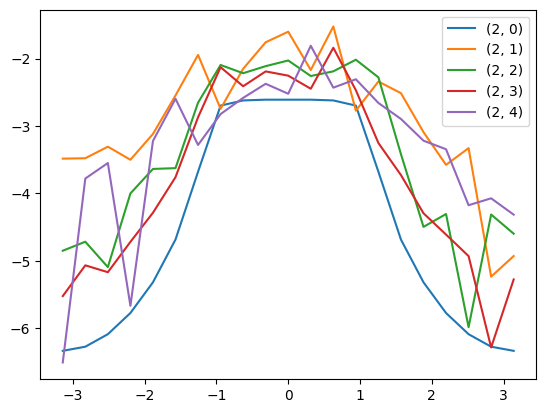

Fig.3 [test_traditional.ipynb](test_traditional.ipynb) $E\sim \Phi_\mathrm{ext}/\Phi_0$

### Benchmark of effective single mode using exact diagonalization:


Hamiltonian of Fig.1.b)
$$H^{\prime} =4{E}_{{\rm{C}}}{n}^{^{\prime} 2}-{N}_{{\rm{J}}}^{2}{E}_{{\rm{L}}}\cos (\phi ^{\prime} /{N}_{{\rm{J}}})-{E}_{{\rm{J}}}\cos (\phi ^{\prime} +{\varphi }_{{\rm{ext}}})\tag{4}$$
for large $N_\mathrm{J}$
$$H=4{E}_{{\rm{C}}}{n}^{^{\prime} 2}+\frac{{E}_{{\rm{L}}}}{2}{\phi }^{^{\prime} 2}-{E}_{{\rm{J}}}\cos (\phi ^{\prime} +{\varphi }_{{\rm{ext}}}),\tag{5}$$

Derivation of its equivalence of Equ $(1)$ in Ref.1


build Hamiltonian and solve in class Fluxonium in [effective_flux.py](effective_flux.py)

100%|██████████| 100/100 [00:00<00:00, 2272.51it/s]


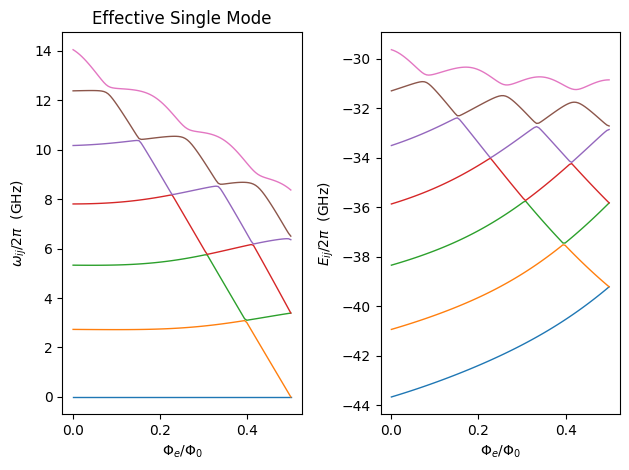

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from effective_flux import Fluxonium    # effective_flux.py

phi_ext_range = np.linspace(0, np.pi / 2, 100)  # the sweep range of phi_ext
N = 7  # the number of lines in the spectrum

energies_ESM = np.zeros((len(phi_ext_range), N))
for n, var in enumerate(tqdm(phi_ext_range)):
    fluxonium = Fluxonium(EJ=7.5, EC=0.48, EL=1.27, phi_ext=var,
                          N_truncation=20, basis='flux',
                          theta_begin=-1, theta_end=1)
    energies_ESM[n, :] = fluxonium.eigenValues(N)

# Plotting the energy spectrum
# Plot frequency
plt.subplot(121)
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ \omega_{ij}/2\pi$  (GHz)')
for i in range(N):
    plt.plot(phi_ext_range / np.pi, (energies_ESM[:, i] - energies_ESM[:, 0]), linewidth='1')
plt.title('Effective Single Mode')
# Plot energy
plt.subplot(122)
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ E_{ij}/2\pi$  (GHz)')
for i in range(N):
    plt.plot(phi_ext_range / np.pi, energies_ESM[:, i], linewidth='1')
plt.tight_layout()

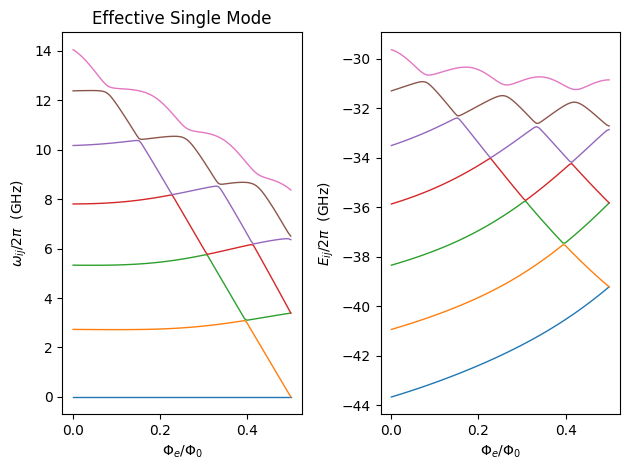

Fig.4 Effective Single Mode result

Good result of multi-targeted DMRG would be same as this figure 

## Multi-targeted DMRG

Main idea is introduce an excitation index:

$$\Psi_{n}=\left(\left|\psi_{1}^{(n)}\right\rangle\left|\psi_{2}^{(n)}\right\rangle\left|\psi_{3}^{(n)}\right\rangle \ldots\left|\psi_{g}^{(n)}\right\rangle\right)\tag{6}$$

$g$ = `N_excited`

In the code, MPS of a site shapes $(d_\text{virtual-left}, d_\text{physical}, d_\text{virtual-right}, g)$

class `Flux` in flux.py:

- `__init__` parameters showed in comment

- `init_MPS()` intialize MPS randomly

- `set_MPO(basis)` build MPO on basis='charge' or 'flux', on flux basis, $\hat{\phi}$ is diagonal; on charge basis, $\hat{n}$ is diagonal.
    
    since $\hat{n}$ is in bidiagonal term of MPO, choosing flux basis is better.

- `set_phiExt(phi_ext)` set $\phi_\mathrm{ext}$ of right environment

- `optimizeT_site(site_)` optimize single site

- `optimizeT(usingLanczos: bool, Eng_criterion: float, N_criterion: int, Quiet: bool)` implement the strictly single-site (3S) vMPS algorithm (Ref.2)
  - `usingLanczos` if `True`, use block Lanczos algorithm(as **next cell**), else just select low energy eigenvectors of H(this method can only calculate 1 excitation)
  - `Eng_criterion` criterion for convergence
  - `N_criterion` choose lowest N states for convergence criterion, if quickly enough, use N_criterion = N_excited

### Block Lanczos

Refer to Ref.2, 

Lanczos steps as

$$\widetilde{\Psi}_{n+1}=\Psi_{n+1} \mathbf{B}_{n+1}=\mathcal{H} \Psi_{n}-\Psi_{n} \mathbf{A}_{n}-\Psi_{n-1} \mathbf{B}_{n}^{\dagger}\tag{7}$$

$$\begin{aligned}
\Psi_{n}^{\dagger} \Psi_{k} & =\mathbb{I}_{g \times g} \delta_{n k}, \\
\mathbf{A}_{n} & =\Psi_{n}^{\dagger} \mathcal{H} \Psi_{n}, \\
\mathbf{B}_{n} & =\Psi_{n}^{\dagger} \mathcal{H} \Psi_{n-1}.
\end{aligned}\tag{8}$$

$$
\begin{array}{l}
\mathbf{U}_{n+1} \mathbf{D}_{n+1} \mathbf{V}_{n+1}^{\dagger} & =\widetilde{\Psi}_{n+1}, \\
\mathbf{U}_{n+1} \mathbf{V}_{n+1}^{\dagger} & \equiv \Psi_{n+1}, \\
\mathbf{V}_{n+1} \mathbf{D}_{n+1} \mathbf{V}_{n+1}^{\dagger} & =\mathbf{B}_{n+1}=\mathbf{B}_{n+1}^{\dagger} .
\end{array}\tag{9}
$$

$\mathbf{A}_{n}$, $\mathbf{B}_{n}$ : $g\times g$ matrix

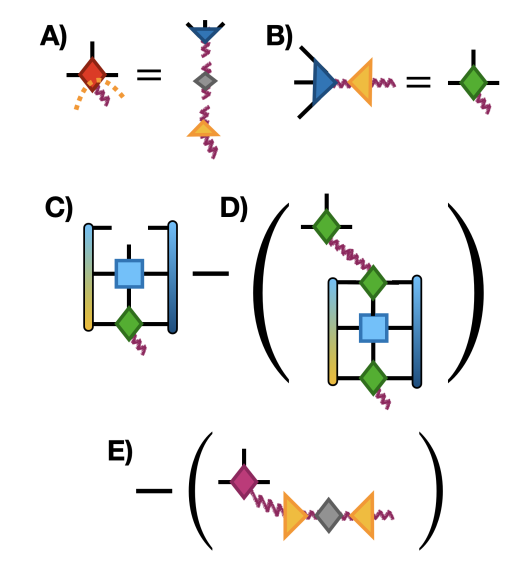

Fig.5 (Fig.2 in Ref.2) The block Lanczos recursion relation formulated in diagrams corresponding to Equ(7)

- A): Equ(9).1
- B): Equ(9).2
- C) to E): Equ(7), get $\mathrm{A}_n$ by Equ(8).2, get $\mathrm{B}_n$ by Equ(9).3

get
$$\check{\mathbf{M}} \equiv \mathbf{T}_{p}^{\dagger} \mathcal{H} \mathbf{T}_{p}  =\left(\begin{array}{ccccc}
\mathbf{A}_{0} & \mathbf{B}_{1}^{\dagger} & \mathbf{0} & \cdots & \mathbf{0} \\
\mathbf{B}_{1} & \mathbf{A}_{1} & \mathbf{B}_{2}^{\dagger} & \cdots & \mathbf{0} \\
\mathbf{0} & \mathbf{B}_{2} & \mathbf{A}_{2} & \ddots & \vdots \\
\vdots & \vdots & \ddots & \ddots & \mathbf{B}_{p}^{\dagger} \\
\mathbf{0} & \mathbf{0} & \cdots & \mathbf{B}_{p} & \mathbf{A}_{p}
\end{array}\right)\tag{10}$$

$p=$`N_Lanczos` $+1$

Diagonalize $\hat{\mathbf{M}}$ to $(E_1,...,E_g)$, $(V_1,...,V_g)$, return
$$\Psi = \oplus_{j} \psi^j = \sum_{n=1}^{p}\sum_{i=1}^{g}V^{nj}_{i}\psi_n^i\tag{11}$$

$i,j$ : excitation index; $n$ : Lanczos index

### Result

#### On flux basis,

In [7]:
# multi-targeted DMRG

from flux import Flux
import numpy as np
from tqdm import tqdm
n_j = 6
n_excited = 12
phi_ext_range = np.linspace(0, np.pi / 2, 41)  # the sweep range of phi_ext
energies = np.zeros((len(phi_ext_range), n_excited))
f = Flux(N_J=n_j, N_excited=n_excited, Ds=12, N_Lanczos=4, basis='flux')
for n, var in enumerate(tqdm(phi_ext_range)):
    f.set_phiExt(var)
    energies[n] = np.array(f.optimizeT(usingLanczos=True, Eng_criterion=0.01, N_criterion=12, Quiet=False))
N = energies.shape[1]  # the number of lines in the spectrum (n_excited)
# Plotting the energy spectrum
energies = energies[::-1, :]
phi_e_range = phi_ext_range / np.pi

  0%|          | 0/41 [00:00<?, ?it/s]

[-106.728 -106.364 -103.735 -103.519 -103.126 -102.547 -101.935  -98.676
[-1.93  -2.226  0.142 -2.072 -2.546 -3.153 -4.128 -7.33  -5.918 -5.371
[-0.037 -0.038 -0.075 -0.515 -0.075 -0.091  0.278 -0.047 -0.053 -0.052
[-0.002 -0.    -0.003  0.356 -0.042 -0.003 -0.324 -0.006 -0.001  0.001
[ 0.     0.001  0.001 -0.359  0.036 -0.001  0.324  0.015 -0.016  0.
[-0.     0.     0.     0.357 -0.031 -0.    -0.324 -0.018  0.017  0.
[ 0.     0.001  0.001 -0.     0.002 -0.     0.    -0.001  0.001  0.001
[ 0.071 -0.071  0.    -0.     0.001 -0.    -0.    -0.001  0.     0.001
[-0.071  0.072 -0.     0.     0.002 -0.     0.    -0.001  0.001  0.002
[-0.     0.     0.    -0.     0.001  0.    -0.     0.023 -0.023 -0.059
[ 0.     0.001  0.    -0.356 -0.287 -0.243  0.12   0.083  0.137  0.235
[ 0.073 -0.073  0.     0.356  0.289  0.243 -0.12  -0.108 -0.112 -0.173


  2%|▏         | 1/41 [01:33<1:02:30, 93.75s/it]

[ 0.001  0.     0.    -0.     0.001 -0.     0.    -0.     0.001  0.001
[-106.636 -106.275 -104.236 -103.939 -103.523 -102.55  -102.121  -99.898
[-2.115 -2.237  0.729  0.498 -1.386 -3.203 -4.025 -6.211 -5.547 -4.798
[ 0.008  0.    -1.974 -2.709 -0.711  0.102  0.413  0.302  0.016 -0.162
[-0.006 -0.001 -0.678  0.61  -0.413 -0.364  0.029  0.054  0.238  0.22
[ 0.001  0.001  0.001  0.001  0.003  0.003 -0.004  0.     0.016 -0.02
[-0.    -0.001 -0.001 -0.     0.017 -0.016 -0.004  0.001 -0.025  0.019
[ 0.    -0.     0.001 -0.001 -0.014  0.019 -0.001 -0.001  0.025 -0.027
[-0.    -0.001  0.     0.    -0.001  0.002  0.003  0.002 -0.031  0.028
[ 0.    -0.     0.    -0.002  0.001  0.002  0.003  0.001  0.03  -0.031
[-0.    -0.001  0.     0.     0.     0.     0.002  0.002 -0.03   0.03
[ 0.    -0.     0.    -0.001  0.001 -0.     0.001  0.     0.03  -0.029
[-0.    -0.     0.616 -0.615  0.321 -0.02  -0.301  0.002  0.     0.
[-0.     0.    -0.    -0.     0.001  0.    -0.001  0.    -0.029  0.03
[-0.    -0.

  5%|▍         | 2/41 [03:03<59:13, 91.11s/it]  

[-0.     0.001 -0.    -0.    -0.    -0.001  0.    -0.     0.002  0.
[-107.864 -106.923 -104.984 -104.422 -103.893 -103.372 -102.909 -103.103
[-1.035 -1.49   1.228  0.4   -0.224 -2.929 -3.37  -3.113 -5.009 -3.727
[ 1.000e-03 -5.000e-03 -1.090e-01 -2.284e+00 -2.150e+00  6.790e-01
[-0.005  0.009 -0.014 -0.006 -0.006 -0.48  -0.426 -0.216  0.007  0.349
[-0.001 -0.002  0.001 -0.001 -0.001  0.017 -0.032 -0.002 -0.002  0.004
[ 0.     0.     0.002  0.     0.001 -0.018  0.012 -0.001  0.     0.007
[-0.001 -0.001 -0.    -0.001 -0.     0.124 -0.007 -0.125 -0.001  0.004
[ 0.     0.001  0.001  0.     0.001  0.329  0.459  0.371  0.001 -0.242
[-0.001 -0.001 -0.001 -0.001 -0.001  0.013 -0.01   0.002 -0.001  0.
[ 0.     0.001  0.001  0.     0.001 -0.194  0.013  0.084  0.103  0.001
[-0.001 -0.    -0.001 -0.001 -0.001  0.196 -0.012 -0.184  0.001 -0.
[ 0.001  0.001  0.001  0.001  0.001 -0.469 -0.463 -0.145 -0.102  0.252
[-0.001 -0.001  0.    -0.001 -0.    -0.008  0.006 -0.    -0.001  0.
[ 0.     0.001  0.00

  7%|▋         | 3/41 [04:53<1:03:12, 99.80s/it]

[ 0.     0.001  0.001  0.     0.     0.    -0.001  0.001  0.001  0.002
[-107.274 -107.034 -104.612 -104.337 -103.899 -103.456 -102.804  -99.655
[-1.705 -1.285  1.317  0.632 -2.473 -2.836 -3.242 -6.078 -3.813 -3.603
[ 0.021  0.032 -3.064 -2.525  0.166  0.154  0.694 -0.025 -0.032 -0.055
[-0.006 -0.002 -0.009  0.005 -0.001 -0.002 -0.643  0.422 -0.006 -0.037
[ 0.001 -0.001  0.001  0.016 -0.019  0.007 -0.002  0.002 -0.001 -0.141
[-0.     0.    -0.    -0.018  0.016  0.002 -0.002 -0.001  0.     0.001
[-0.     0.002  0.     0.017 -0.018 -0.001 -0.006 -0.004  0.002  0.011
[-0.     0.002 -0.    -0.02   0.018 -0.006 -0.01  -0.009  0.002  0.018
[ 0.     0.002  0.     0.001  0.004 -0.004 -0.02  -0.363  0.343  0.122
[ 0.     0.001  0.     0.002  0.003  0.003 -0.017  0.001 -0.025  0.015


 10%|▉         | 4/41 [06:05<54:53, 89.01s/it]  

[ 0.     0.     0.     0.001  0.     0.003 -0.005  0.    -0.009  0.006
[-107.459 -106.644 -104.259 -103.874 -103.601 -103.055 -102.78  -101.781
[-1.647 -1.502  0.754 -0.139 -1.39  -2.364 -2.792 -4.249 -5.313 -5.76
[-0.021 -0.036 -0.491 -0.066 -0.619 -0.014  0.088 -0.264 -0.031 -0.042
[-0.002 -0.002 -0.092  0.031 -0.004 -0.018 -0.008  0.007 -0.003 -0.002
[ 0.    -0.002 -0.002 -0.011 -0.001 -0.041  0.045 -0.005  0.     0.002
[-0.001 -0.    -0.003 -0.005  0.173  0.002 -0.168 -0.005 -0.001 -0.001
[ 0.001  0.001  0.03  -0.031 -0.172  0.057  0.128 -0.006  0.001  0.001
[-0.001  0.002 -0.031  0.029  0.188 -0.048 -0.125 -0.007 -0.001 -0.001
[ 0.     0.003  0.03  -0.03   0.004  0.006  0.003 -0.004  0.     0.001
[-0.001  0.004 -0.031  0.03  -0.182  0.057  0.139 -0.003 -0.001 -0.001
[ 0.001  0.004  0.032 -0.03   0.004  0.002  0.006 -0.002  0.001  0.001
[-0.001  0.004  0.    -0.001  0.005  0.002  0.006 -0.002 -0.001 -0.001
[ 0.     0.004  0.001  0.001  0.005 -0.035  0.043 -0.001  0.     0.
[-0.001 

 12%|█▏        | 5/41 [07:55<57:50, 96.39s/it]

[-0.001  0.004 -0.     0.     0.005 -0.     0.006  0.    -0.001 -0.001
[-107.092 -105.641 -104.267 -103.647 -103.263 -102.617  -99.663 -101.806
[-2.113 -2.401  0.157 -2.586 -3.333 -3.946 -6.746 -4.685 -3.605 -4.274
[-0.023 -0.027 -0.05  -0.045 -0.028 -0.024 -0.079  0.062 -0.467  0.046
[-0.001 -0.001 -0.003 -0.346  0.037  0.309  0.01   0.01  -0.004 -0.
[-0.001  0.002 -0.001 -0.001 -0.     0.     0.059 -0.055  0.002  0.004
[-0.001  0.    -0.001 -0.001 -0.001 -0.    -0.001  0.004  0.     0.002
[-0.     0.002  0.     0.348 -0.038 -0.31  -0.051  0.05   0.002  0.003
[-0.     0.     0.001 -0.    -0.    -0.     0.05  -0.05  -0.     0.114
[-0.     0.002  0.001 -0.349  0.037  0.312 -0.053  0.05   0.002 -0.11
[-0.    -0.     0.001 -0.    -0.    -0.     0.053 -0.055 -0.     0.
[ 0.     0.001  0.001  0.    -0.     0.    -0.059  0.055  0.001  0.001
[-0.    -0.001  0.001 -0.     0.     0.    -0.001  0.    -0.001 -0.


 15%|█▍        | 6/41 [09:16<53:20, 91.45s/it]

[ 0.     0.001  0.001  0.     0.     0.    -0.001 -0.     0.001  0.001
[-106.913 -105.036 -104.449 -102.958 -102.538 -102.05  -101.606 -101.426
[-2.409 -2.872  0.355 -1.275 -3.787 -4.659 -5.061 -5.186 -5.515 -5.463
[-0.019 -0.03  -0.105 -0.056  0.949  1.496  1.41   0.12  -0.178 -1.512
[-0.    -0.005 -0.021 -0.003 -0.006 -0.045  0.051 -0.017 -0.001 -0.001
[-0.001 -0.002 -0.073  0.059 -0.002 -0.001  0.004 -0.002 -0.001 -0.
[ 0.     0.     0.054 -0.06  -0.     0.063 -0.056 -0.004  0.     0.04
[-0.     0.002 -0.005 -0.001  0.002  0.004  0.004 -0.004 -0.    -0.038


 17%|█▋        | 7/41 [10:06<44:02, 77.72s/it]

[ 0.     0.003 -0.003  0.     0.003  0.003  0.006 -0.004  0.     0.001
[-107.04  -106.308 -104.379 -103.391 -103.295 -102.738 -102.103 -101.668
[-2.364 -1.491 -2.409 -3.338 -3.392 -3.562 -3.865 -2.51  -2.969 -4.367
[-0.026 -0.028  0.331  0.146 -0.134 -0.48  -0.753 -0.169 -0.645 -0.173
[ 0.    -0.    -0.044 -0.237  0.205  0.007  0.017 -0.001 -0.329  0.256
[-0.001  0.003 -0.009 -0.    -0.156  0.062  0.085 -0.004  0.003  0.002
[-0.002  0.003 -0.     0.201 -0.05  -0.064 -0.097 -0.004  0.003 -0.148
[-0.002  0.003  0.003 -0.204  0.045  0.152 -0.003 -0.003  0.003  0.006
[-0.001  0.003  0.003  0.201 -0.047 -0.158  0.    -0.002  0.003  0.149
[-0.001  0.002  0.002 -0.203  0.042  0.156  0.001 -0.002  0.002 -0.141
[-0.001  0.002  0.002  0.201 -0.044 -0.16   0.002 -0.001  0.002  0.142
[-0.001  0.001  0.002 -0.202  0.2   -0.002  0.002 -0.001  0.001 -0.001
[-0.001  0.001  0.002 -0.001 -0.161  0.076  0.085 -0.     0.001 -0.001
[-0.001  0.    -0.333  0.04   0.293  0.003 -0.001 -0.001  0.    -0.002
[-0.

 20%|█▉        | 8/41 [12:08<50:34, 91.95s/it]

[-0.    -0.     0.001 -0.    -0.001  0.     0.001  0.    -0.     0.
[-107.049 -104.938 -104.481 -104.086 -102.607 -101.899 -101.704 -101.373
[-2.482 -2.746 -2.183 -2.825 -4.266 -4.895 -5.037 -3.743 -3.862 -3.811
[-0.013 -0.012  1.526  1.921  2.609  2.319  2.296 -1.609 -1.936 -2.81
[-1.000e-03  3.000e-03 -1.562e+00 -1.941e+00 -2.643e+00 -2.392e+00
[-0.002  0.002  0.018 -0.002 -0.002  0.002 -0.003 -0.002  0.009 -0.04
[ 2.000e-03  0.000e+00  2.379e+00  2.477e+00  1.772e+00  2.069e+00
[-1.000e-03 -2.000e-03 -2.361e+00 -2.476e+00 -1.691e+00 -2.071e+00]
[ 0.     0.002  0.002  0.156 -0.106 -0.002  0.002 -0.023  0.005  0.002
[ 0.002  0.004 -0.268 -0.118  0.062  0.129  0.222 -0.024  0.007  0.004
[ 0.002  0.004  0.228  0.17  -0.058 -0.128 -0.219 -0.017  0.007  0.004
[ 0.003  0.004 -0.03  -0.033  0.003 -0.    -0.001 -0.013  0.005  0.004
[ 0.001  0.003 -0.021 -0.06   0.001 -0.    -0.005 -0.016 -0.001  0.003
[-0.004 -0.003 -0.006 -0.112  0.021  0.024  0.028 -0.712 -0.542  0.2
[-0.004 -0.     1.636 

 22%|██▏       | 9/41 [14:15<54:49, 102.79s/it]

[-0.     0.005  0.001 -0.     0.     0.     0.     0.001 -0.001  0.005
[-107.256 -105.17  -104.321 -103.948 -103.342 -102.942 -102.516 -101.673
[-2.353 -2.367 -2.319 -3.035 -3.53  -4.01  -4.399 -3.249 -3.987 -3.781
[-0.036 -0.036  1.621  2.097  2.575  2.383  2.432 -1.787 -2.237 -2.792
[-1.000e-03  2.000e-03 -1.707e+00 -2.144e+00 -2.701e+00 -2.394e+00
[-2.000e-03  3.000e-03  2.494e+00  2.014e+00  2.118e+00  2.445e+00]
[-0.001  0.002 -0.017  0.002 -0.001 -0.012 -0.    -0.001 -0.002 -0.008


 24%|██▍       | 10/41 [15:08<45:12, 87.50s/it]

[ 0.     0.001 -0.002  0.001  0.002 -0.004  0.003 -0.     0.    -0.
[-107.924 -105.594 -105.338 -104.965 -103.138 -102.663 -100.101 -102.212
[-1.808 -1.831 -1.357 -1.954 -3.969 -4.397 -6.927 -2.627 -2.191 -3.51
[-0.013 -0.024  1.794  2.153  2.438  2.619  2.638 -2.287 -2.698 -2.628
[-0.001 -0.001 -0.003 -0.008 -0.001  0.053 -0.062 -0.001 -0.003 -0.001
[-0.001  0.     0.     0.385  0.208 -0.385 -0.219  0.085 -0.087  0.002
[-0.     0.    -2.224 -2.654 -2.602 -2.313 -2.425  2.138  2.739  2.592
[-0.     0.001 -0.     0.001  0.001  0.    -0.     0.001 -0.385 -0.198
[-0.000e+00  1.000e-03  2.226e+00  2.648e+00  2.563e+00  2.313e+00
[-1.000e-03  0.000e+00 -2.227e+00 -2.648e+00 -2.564e+00 -2.311e+00]
[-0.     0.001 -0.    -0.002 -0.001 -0.011  0.013  0.001  0.001 -0.015
[-0.000e+00  1.000e-03  2.230e+00  2.272e+00  2.674e+00  2.426e+00
[-0.     0.001  0.513 -0.127 -0.381  0.112 -0.126 -0.    -0.003  0.031
[-0.     0.001  0.002  0.001  0.202 -0.112 -0.1   -0.    -0.002 -0.032
[-0.     0.001  0.0

 27%|██▋       | 11/41 [22:38<1:39:10, 198.36s/it]

[-108.598 -105.829 -105.367 -105.28  -104.823 -103.701 -102.677 -102.905
[-1.245 -1.454 -1.689 -1.832 -2.395 -3.488 -4.48  -1.522 -2.582 -3.263
[-0.005 -0.019 -0.169 -0.087  0.043  0.04   0.002 -0.056 -0.039 -0.164
[ 0.001  0.008  0.001  0.002  0.001 -0.003 -0.    -0.284 -0.194  0.096
[-0.    -0.008 -0.     0.001  0.001 -0.003 -0.006  0.283  0.231 -0.093
[-0.001 -0.007 -0.001  0.     0.017 -0.023 -0.008 -0.004 -0.003 -0.001
[-0.001 -0.005 -0.001 -0.001 -0.002  0.008 -0.009 -0.279 -0.228  0.068
[-0.001 -0.    -0.001 -0.001 -0.019  0.01   0.014  0.274  0.254 -0.065
[-0.001 -0.002 -0.001 -0.001  0.     0.001  0.004 -0.271 -0.253  0.06
[-0.    -0.001 -0.    -0.001 -0.001  0.003 -0.001  0.001  0.    -0.002


 29%|██▉       | 12/41 [24:38<1:24:23, 174.61s/it]

[ 0.    -0.003  0.     0.001  0.001  0.001 -0.002  0.002  0.    -0.004
[-108.366 -105.742 -105.55  -105.11  -104.847 -104.277 -103.049 -102.607
[-1.571 -1.348 -1.569 -2.2   -2.431 -2.952 -4.203 -2.225 -2.824 -3.239
[-0.009  0.009 -0.202  0.058  0.01  -0.064 -0.028 -0.029 -0.033 -0.135
[ 0.001  0.098  0.001 -0.003 -0.035  0.009  0.008 -0.001  0.    -0.019
[-0.001  0.056 -0.001 -0.055  0.046 -0.004 -0.003 -0.004  0.003 -0.017
[ 0.     0.003  0.     0.053 -0.049  0.     0.     0.001  0.001 -0.008
[-0.     0.002  0.065 -0.064  0.018 -0.016 -0.     0.     0.001 -0.007
[-0.     0.    -0.065  0.066  0.014  0.001 -0.011  0.039 -0.039 -0.003
[ 0.     0.001  0.066 -0.013 -0.047  0.017 -0.017 -0.039  0.039 -0.
[ 0.001  0.    -0.066 -0.037  0.065  0.024  0.019  0.001  0.001  0.004
[ 0.     0.001  0.    -0.001 -0.028  0.004  0.029  0.001  0.001  0.008
[-0.     0.002 -0.     0.     0.     0.     0.     0.273 -0.037 -0.221
[-0.001  0.004 -0.001  0.003 -0.001  0.003 -0.004  0.017  0.001 -0.001
[-0.001

 32%|███▏      | 13/41 [28:47<1:31:54, 196.94s/it]

[ 0.    -0.     0.005  0.     0.     0.     0.     0.002  0.001 -0.
[-109.133 -106.419 -106.12  -105.587 -104.398 -103.724 -103.301 -102.728
[-0.903 -0.282 -1.193 -1.755 -2.966 -3.683 -4.09  -2.209 -2.416 -2.621
[-0.004 -0.085 -0.101 -0.062 -0.018  0.031  0.019 -0.018 -0.035 -0.036
[ 0.001 -0.006  0.064 -0.008 -0.021 -0.006  0.002  0.287  0.185 -0.257
[-0.001 -0.004  0.001 -0.001  0.001 -0.     0.004  0.001  0.008 -0.029
[ 0.     0.    -0.     0.     0.001 -0.     0.003 -0.288 -0.192  0.289
[ 0.    -0.001 -0.065  0.014  0.019  0.035  0.003  0.291  0.197 -0.167
[ 0.001  0.001  0.068  0.043 -0.03  -0.052 -0.021  0.001 -0.002 -0.12
[ 0.001 -0.     0.005  0.004  0.001  0.001 -0.    -0.    -0.219  0.033
[ 0.     0.     0.008  0.001  0.     0.001  0.    -0.286  0.034  0.254
[-0.     0.     0.005 -0.001 -0.    -0.     0.001  0.281  0.17  -0.147
[-0.     0.001 -0.002 -0.001 -0.    -0.     0.001 -0.281 -0.167 -0.006
[-0.     0.001 -0.007 -0.058  0.056  0.019 -0.016  0.279  0.165 -0.008
[-0.    

 34%|███▍      | 14/41 [33:31<1:40:30, 223.37s/it]

[-0.001 -0.001  0.009 -0.001  0.001 -0.     0.     0.001  0.002 -0.001
[-108.878 -105.973 -105.75  -104.206 -103.623 -103.163 -103.256 -102.445
[-1.246 -0.691 -1.354 -3.285 -3.836 -4.17  -4.13  -2.21  -3.125 -3.965
[-0.011 -0.007 -0.27  -0.013 -0.016 -0.085 -0.053 -0.359 -0.332  0.023
[ 0.     0.    -0.129  0.029  0.084 -0.009 -0.006 -0.    -0.002  0.015
[ 0.     0.     0.     0.078 -0.084 -0.004  0.     0.    -0.     0.007
[ 0.001  0.002  0.001 -0.005  0.001 -0.015  0.013  0.001  0.001  0.004
[-0.    -0.001  0.099 -0.102  0.     0.001 -0.003 -0.029  0.03   0.079
[ 0.001  0.001 -0.099  0.097  0.001  0.007 -0.008  0.001  0.002  0.004


 37%|███▋      | 15/41 [34:41<1:16:44, 177.10s/it]

[-0.    -0.002 -0.    -0.001  0.    -0.004  0.003  0.     0.001  0.003
[-107.991 -105.054 -104.576 -104.404 -103.854 -102.501 -102.338  -99.435
[-2.223 -1.7   -2.7   -2.995 -3.72  -5.042 -5.142 -4.737 -4.942 -3.45
[-0.015 -0.045 -0.318 -0.109  0.044 -0.    -0.083 -0.081 -0.035 -0.095
[-0.002  0.    -0.002  0.006 -0.003 -0.021  0.014 -0.006 -0.001  0.003
[-0.001  0.002  0.101 -0.095  0.001  0.017 -0.016 -0.003 -0.001  0.007
[-0.001  0.003  0.005 -0.001  0.001  0.002 -0.001 -0.011 -0.     0.006
[-0.001  0.004 -0.108  0.111 -0.035  0.014  0.024 -0.04  -0.001  0.006
[ 0.     0.029  0.    -0.    -0.001  0.001  0.003 -0.807  0.561  0.003
[ 0.002  0.234  0.001 -0.032  0.028 -0.041 -0.019 -0.001 -0.478  0.213
[-0.002  0.008 -0.002  0.002 -0.002 -0.002 -0.003  0.312 -0.089 -0.078
[-0.001 -0.003  0.084 -0.083 -0.032  0.033  0.009  0.018  0.237 -0.23
[-0.    -0.002 -0.086  0.028  0.054  0.     0.007  0.007  0.006  0.
[-0.     0.001 -0.    -0.    -0.006 -0.004  0.006  0.001  0.001  0.001
[-0.     

 39%|███▉      | 16/41 [36:33<1:05:37, 157.51s/it]

[-0.     0.002 -0.    -0.     0.001 -0.007  0.006 -0.    -0.     0.
[-108.338 -105.397 -104.704 -104.124 -103.63  -102.397 -101.765 -101.301
[-1.96  -1.164 -2.648 -3.357 -4.026 -5.228 -5.812 -2.646 -3.318 -4.25
[-0.023 -0.076 -0.15  -0.202  0.072 -0.03  -0.051 -0.226 -0.737 -0.384
[ 1.00e-03  2.70e-01 -1.81e-01  3.00e-02 -4.20e-02  5.90e-02  3.80e-02
[-0.001  0.047 -0.001 -0.004  0.034 -0.029 -0.021 -0.005 -0.003 -0.05


 41%|████▏     | 17/41 [37:09<48:25, 121.07s/it]  

[ 0.     0.005  0.     0.    -0.002  0.001 -0.001  0.     0.001 -0.004
[-109.163 -106.438 -106.262 -105.528 -103.94  -103.448 -103.722 -102.963
[-1.242  0.199 -1.501 -2.208 -3.771 -4.231 -3.966 -2.314 -2.837 -4.547
[-0.008 -0.044 -0.01  -0.017 -0.03  -0.029 -0.029 -0.017 -0.027 -0.236
[-0.    -0.002  0.     0.002  0.     0.002  0.002 -0.002  0.001  0.121
[ 0.     0.001  0.     0.047  0.025 -0.044 -0.025 -0.     0.    -0.133
[ 0.001  0.002  0.001  0.002 -0.032  0.011  0.024  0.28   0.203 -0.012
[ 0.001  0.     0.001 -0.001  0.029 -0.005 -0.022  0.003 -0.003 -0.016
[ 0.001  0.002  0.    -0.001 -0.001  0.009 -0.004  0.004 -0.003 -0.015
[ 0.     0.003  0.    -0.002  0.001 -0.005  0.009  0.007 -0.002 -0.013
[ 0.     0.003  0.    -0.034 -0.012  0.037  0.018  0.012  0.002 -0.086
[ 0.    -1.497  0.087  0.028 -0.012 -0.025  1.524  0.02   0.006  0.069
[-0.003  0.157 -0.089 -0.001  0.014 -0.016  0.008  0.028  0.006 -0.069
[-0.003  1.435 -0.003 -0.033  0.039  0.03  -1.529 -0.349 -0.207  0.233


 44%|████▍     | 18/41 [38:36<42:30, 110.90s/it]

[-0.001  0.001 -0.001 -0.002  0.002  0.002 -0.004  0.    -0.001  0.001
[-109.185 -106.458 -105.776 -104.62  -104.005 -103.278 -103.142 -102.457
[-1.304 -1.218 -2.066 -3.123 -3.779 -4.525 -2.862 -1.883 -2.718 -3.852
[-0.011  1.536 -0.016 -0.081 -0.032  0.013 -1.79  -1.006 -0.453 -0.051
[-0.    -1.717  0.089  0.     0.    -0.011  1.646 -0.031  0.029  0.015
[-0.     0.208 -0.089 -0.003  0.002 -0.02  -0.001  0.269  0.213 -0.183
[ 3.000e-03  1.499e+00  1.220e-01 -2.800e-02  2.000e-03 -7.000e-03
[ 1.000e-03 -1.625e+00 -1.180e-01  4.600e-02 -1.500e-02  7.000e-03]
[-1.000e-03  1.625e+00 -1.000e-03  1.800e-02  2.000e-02 -7.000e-03]
[-0.001  0.    -0.001 -0.006  0.001 -0.    -0.002 -0.002 -0.004  0.061
[-0.001 -0.    -0.001 -0.002  0.001  0.001 -0.     0.002 -0.002 -0.063
[-0.    -0.001 -0.    -0.001  0.     0.004 -0.002  0.004  0.     0.001
[ 0.     0.001  0.    -0.001  0.001 -0.002  0.005  0.007  0.002  0.001
[-0.     0.001 -0.    -0.024 -0.011  0.023  0.016  0.009  0.003  0.001
[-0.     0.002

 46%|████▋     | 19/41 [40:52<43:22, 118.31s/it]

[-0.     0.002 -0.    -0.    -0.     0.001  0.001  0.001  0.002 -0.
[-108.726 -105.742 -105.258 -104.664 -103.305 -102.887 -102.351 -102.073
[-1.852 -1.631 -2.671 -3.228 -4.47  -4.916 -3.61  -3.368 -4.166 -4.455
[-0.01  -0.569  0.094 -0.019 -0.084 -0.078 -0.05  -0.017 -0.032  0.062
[ 0.     0.     0.012  0.054 -0.02  -0.031 -0.01  -0.002 -0.001 -0.013
[-0.001 -0.001 -0.091  0.028  0.001  0.054 -0.001  0.024 -0.028 -0.002
[ 0.001  0.001  0.078 -0.084  0.02  -0.02   0.     0.268  0.251 -0.078
[-0.001 -0.001 -0.078  0.068 -0.019  0.017  0.001 -0.294 -0.227 -0.001
[ 0.001  0.001  0.    -0.033  0.027 -0.001 -0.     0.001  0.001  0.002


 49%|████▉     | 20/41 [41:45<34:34, 98.81s/it] 

[-0.001 -0.001 -0.001 -0.    -0.005 -0.003  0.001 -0.001  0.    -0.
[-109.452 -106.633 -106.148 -105.398 -104.519 -103.758 -103.362 -102.769
[-1.218 -1.21  -1.873 -2.588 -3.434 -4.165 -2.504 -2.298 -2.667 -4.136
[-0.005 -0.049 -0.007  0.023 -0.033 -0.074 -0.019 -0.135 -0.119 -0.225
[-0.     0.02  -0.001 -0.001 -0.001 -0.001 -0.001 -0.002 -0.002  0.07
[ 0.001  0.029  0.001 -0.     0.001  0.     0.001 -0.003  0.003 -0.072
[-0.     0.027 -0.    -0.001  0.001 -0.     0.001 -0.01   0.003  0.
[ 0.001  0.006  0.001 -0.     0.002  0.001 -0.001 -0.009  0.002  0.078
[-0.    -0.005 -0.    -0.031  0.017  0.018  0.    -0.002  0.002 -0.076
[ 0.001 -0.019  0.001  0.001  0.002  0.003 -0.001 -0.027  0.029  0.065
[-0.001 -0.037 -0.001 -0.001  0.003  0.002  0.003  0.025 -0.032 -0.064
[ 0.    -0.155  0.111 -0.     0.003  0.001  0.004 -0.043  0.03   0.001
[-0.001 -0.001 -0.083  0.057 -0.017  0.012  0.012  0.045 -0.056 -0.
[-0.001  0.09  -0.03  -0.061 -0.002 -0.008  0.038  0.002 -0.005  0.001
[-0.001 -0.092

 51%|█████     | 21/41 [44:50<41:32, 124.62s/it]

[ 0.    -0.     0.     0.    -0.     0.     0.     0.001  0.001  0.
[-109.248 -106.429 -106.027 -105.372 -104.763 -103.798 -103.065 -100.44
[-1.503 -1.267 -1.966 -2.654 -3.334 -4.277 -2.162 -5.148 -4.417 -2.878
[-0.012 -0.416 -0.086  0.005  0.055  0.029 -0.409 -0.011 -0.046  0.152
[-0.001 -0.001 -0.002 -0.008 -0.007  0.005 -0.086 -0.013 -0.01  -0.061
[-0.001 -0.001  0.07  -0.051 -0.002 -0.004 -0.028  0.028 -0.031  0.051
[ 0.001  0.147 -0.102  0.002 -0.002  0.    -0.    -0.03   0.033 -0.082
[ 0.     0.031  0.     0.    -0.002  0.    -0.001  0.     0.001 -0.023
[-0.     0.022 -0.    -0.    -0.002  0.001  0.001  0.001  0.001 -0.019
[-0.     0.017 -0.    -0.     0.013 -0.014 -0.     0.282  0.201 -0.017
[-0.     0.017 -0.     0.036 -0.015 -0.022  0.     0.007 -0.002 -0.019
[-0.001  0.02  -0.001 -0.037 -0.     0.034 -0.001  0.011 -0.234 -0.025
[-0.001  0.018 -0.001  0.03   0.    -0.035  0.457 -0.066 -0.14  -0.029
[ 0.    -0.003 -0.    -0.03   0.005  0.023 -0.458  0.096  0.374 -0.074
[ 0.001 

 54%|█████▎    | 22/41 [46:54<39:21, 124.29s/it]

[-0.    -0.    -0.    -0.001  0.    -0.    -0.001 -0.     0.005  0.
[-109.569 -106.813 -106.001 -105.327 -104.449 -103.813 -103.621 -102.236
[-1.271 -1.371 -2.154 -2.786 -3.627 -4.278 -1.688 -3.178 -3.563 -5.339
[-0.007 -0.009 -0.012 -0.013 -0.055 -0.049 -0.08  -0.059 -0.023 -0.026
[ 0.     0.     0.    -0.002 -0.009  0.008 -0.001 -0.002  0.     0.
[-0.001 -0.001 -0.001 -0.012  0.011 -0.001 -0.001 -0.    -0.    -0.001
[ 0.     0.     0.     0.001  0.     0.001  0.001  0.001  0.001  0.001
[-0.001 -0.001 -0.001 -0.    -0.    -0.    -0.    -0.001  0.081  0.032
[-0.    -0.     0.    -0.001  0.001 -0.    -0.    -0.001 -0.081 -0.031
[-0.    -0.    -0.     0.013 -0.004 -0.009 -0.001 -0.001  0.087 -0.025
[ 0.     0.     0.    -0.015  0.002  0.016  0.001  0.001  0.006  0.
[-0.    -0.    -0.     0.     0.009 -0.004  0.002  0.002  0.03   0.
[-0.001 -0.001 -0.001  0.025 -0.02   0.001  0.002  0.001  0.047  0.


 56%|█████▌    | 23/41 [48:14<33:21, 111.19s/it]

[-0.001 -0.001 -0.001  0.001 -0.    -0.001 -0.002 -0.001  0.007 -0.
[-110.121 -107.274 -107.063 -106.779 -104.96  -104.642 -104.361 -104.055
[-0.801 -0.857 -1.199 -1.47  -3.228 -3.574 -0.884 -1.703 -2.341 -2.995
[-0.004 -0.14   0.053  0.023 -0.048 -0.038 -0.248 -0.019 -0.032 -0.205
[ 0.     0.    -0.042  0.013  0.001  0.03  -0.001 -0.001 -0.001 -0.014
[-0.    -0.     0.001 -0.022  0.012  0.014  0.001  0.    -0.     0.001
[ 0.     0.     0.045  0.014 -0.012 -0.039  0.001  0.001  0.001 -0.
[-0.     0.072 -0.065 -0.001 -0.001  0.002 -0.003  0.21   0.162 -0.066
[-0.001  0.012 -0.001 -0.023  0.001  0.021 -0.281 -0.185 -0.126  0.275
[-0.001  0.014 -0.001 -0.002 -0.001  0.004  0.271  0.037 -0.038 -0.275
[-0.     0.015 -0.    -0.001 -0.002  0.004 -0.271 -0.037  0.04   0.269
[-0.001 -0.027 -0.001  0.035 -0.003 -0.018  0.    -0.     0.003 -0.048
[-0.    -0.089  0.083  0.     0.005 -0.005  0.279  0.239  0.157 -0.22
[-0.    -0.    -0.004 -0.    -0.006  0.006 -0.279 -0.239 -0.155  0.228


 59%|█████▊    | 24/41 [49:40<29:20, 103.53s/it]

[-0.    -0.    -0.005 -0.002  0.006 -0.007  0.    -0.    -0.002  0.002
[-109.666 -106.994 -106.397 -106.449 -104.716 -104.175 -103.501 -100.985
[-1.338 -1.229 -1.84  -1.894 -3.587 -4.136 -1.789 -4.839 -4.327 -2.431
[-0.004 -0.057 -0.06  -0.006 -0.035 -0.009 -0.082 -0.021 -0.048 -0.12
[ 0.     0.002 -0.003  0.     0.001 -0.    -0.006 -0.002 -0.001 -0.001
[-0.001  0.001 -0.05   0.017  0.017  0.019  0.001  0.27   0.173 -0.155
[ 0.001 -0.073  0.074  0.036  0.002 -0.027  0.013  0.     0.004 -0.011
[-0.    -0.    -0.001  0.003  0.003  0.003  0.009 -0.27  -0.178 -0.012
[ 0.     0.     0.002  0.004  0.003  0.001  0.001  0.279  0.179 -0.01
[ 0.     0.     0.003 -0.031  0.002  0.035 -0.005  0.007  0.001 -0.081
[ 0.     0.     0.004  0.033  0.002 -0.033 -0.006  0.008  0.002  0.002
[-0.001 -0.001  0.002 -0.004 -0.011  0.011 -0.016  0.006  0.001  0.
[-0.001  0.085 -0.085 -0.003  0.009 -0.013 -0.033  0.004  0.003  0.055
[-0.001 -0.088  0.085 -0.     0.002 -0.002 -0.044  0.003  0.005 -0.057
[-0.001 -

 61%|██████    | 25/41 [52:03<30:48, 115.51s/it]

[-0.    -0.    -0.    -0.    -0.     0.     0.    -0.001 -0.     0.
[-109.816 -107.078 -106.604 -105.861 -104.552 -103.874 -103.761 -103.06
[-1.258 -0.986 -1.804 -2.459 -3.821 -4.475 -1.381 -2.825 -3.011 -3.692
[-0.011 -0.265 -0.017 -0.073  0.004 -0.031 -0.038 -0.036 -0.049 -0.201
[ 0.    -0.096  0.075 -0.001 -0.011  0.01  -0.015  0.284  0.243 -0.079
[-0.001 -0.001 -0.045  0.037  0.011 -0.01  -0.001 -0.287 -0.221  0.026
[-0.001 -0.001 -0.001 -0.002 -0.011  0.01  -0.015 -0.001 -0.028  0.025
[-0.    -0.     0.    -0.001  0.    -0.001 -0.029 -0.    -0.001 -0.
[-0.    -0.     0.    -0.005 -0.001 -0.001 -0.054 -0.     0.029 -0.029
[-0.    -0.    -0.001 -0.004  0.004 -0.01  -0.121  0.278  0.202 -0.025
[-0.002 -0.001 -0.003 -0.    -0.009  0.003 -0.511 -0.255 -0.199  0.32
[-0.006 -0.006 -0.027 -0.015 -0.008 -0.02  -0.015 -0.022 -0.006 -0.135


 63%|██████▎   | 26/41 [53:16<25:39, 102.65s/it]

[-0.001 -0.001 -0.001 -0.002 -0.007  0.004 -0.002 -0.001 -0.    -0.002
[-109.691 -106.713 -106.022 -105.913 -103.946 -103.583 -102.789 -100.291
[-1.466 -1.592 -2.469 -2.539 -4.451 -4.832 -3.174 -5.634 -4.591 -3.356
[-0.011 -0.2    0.061 -0.02  -0.056 -0.047 -0.033 -0.044 -0.339 -0.041
[-0.    -0.     0.001  0.018 -0.012 -0.011 -0.001 -0.002 -0.01   0.009
[-0.001 -0.001 -0.001 -0.019  0.     0.02   0.327  0.214  0.169 -0.317
[-0.    -0.    -0.003 -0.    -0.    -0.001  0.008 -0.017  0.022  0.
[-0.    -0.    -0.002  0.02  -0.    -0.02   0.004  0.024 -0.021 -0.
[-0.    -0.    -0.001 -0.    -0.009  0.009  0.002 -0.025  0.029  0.
[-0.    -0.    -0.001  0.    -0.    -0.001  0.001  0.032 -0.029  0.
[-0.    -0.    -0.     0.    -0.    -0.     0.     0.004 -0.     0.
[-0.    -0.    -0.001 -0.022  0.008  0.013 -0.     0.004  0.     0.
[-0.    -0.    -0.     0.023 -0.    -0.022 -0.     0.005  0.     0.001


 66%|██████▌   | 27/41 [54:33<22:08, 94.89s/it] 

[-0.    -0.    -0.     0.001 -0.    -0.    -0.     0.005  0.     0.001
[-109.865 -107.055 -106.698 -106.068 -104.349 -103.638 -103.37  -102.96
[-1.375 -1.418 -1.874 -2.44  -4.178 -4.914 -2.388 -2.839 -3.263 -4.268
[-0.005 -0.054 -0.007 -0.034 -0.036 -0.008 -0.031 -0.071 -0.046 -0.025
[ 0.001 -0.002  0.037 -0.012 -0.015 -0.012 -0.007 -0.2   -0.156  0.044
[-0.     0.001  0.     0.001 -0.    -0.004  0.    -0.     0.016 -0.018


 68%|██████▊   | 28/41 [55:07<16:36, 76.64s/it]

[ 0.     0.    -0.001  0.     0.003 -0.002  0.    -0.     0.001 -0.001
[-109.925 -107.033 -106.939 -106.425 -105.909 -104.907 -104.008 -102.174
[-1.389 -1.529 -1.704 -2.197 -2.683 -3.699 -1.758 -3.65  -3.541 -3.376
[-0.008 -0.091  0.056  0.018 -0.023 -0.021 -0.372 -0.276 -0.172  0.189
[ 0.     0.    -0.008 -0.023  0.002  0.019  0.283  0.229  0.166 -0.223
[-0.001 -0.001 -0.032  0.028  0.002 -0.008 -0.285 -0.207 -0.198  0.233
[ 0.     0.     0.028 -0.028 -0.004  0.002  0.    -0.032  0.027  0.003
[-0.    -0.     0.     0.    -0.002 -0.001 -0.    -0.003 -0.002  0.052
[ 0.     0.     0.001  0.001  0.004 -0.005  0.     0.03  -0.031  0.001
[-0.    -0.     0.001  0.    -0.005  0.004  0.    -0.032  0.03   0.
[ 0.     0.     0.001  0.001  0.004 -0.004  0.001  0.032 -0.031  0.001
[-0.    -0.     0.001  0.    -0.001 -0.     0.    -0.032  0.033  0.001


 71%|███████   | 29/41 [56:21<15:09, 75.77s/it]

[ 0.     0.     0.002  0.    -0.004  0.004  0.001  0.     0.001  0.002
[-110.195 -107.43  -106.992 -105.581 -105.377 -104.403 -104.297 -103.186
[-1.195 -1.285 -1.699 -3.001 -3.237 -4.24  -1.459 -2.64  -4.677 -3.794
[-0.006  0.112  0.05  -0.142 -0.073 -0.057 -0.139 -0.126 -0.045 -0.02
[ 0.001  0.007  0.009  0.001 -0.     0.    -0.004  0.019 -0.032 -0.002
[ 0.001  0.006  0.004  0.002  0.001  0.001 -0.001 -0.002 -0.002  0.


 73%|███████▎  | 30/41 [56:58<11:48, 64.39s/it]

[ 0.001  0.005  0.001  0.001  0.002 -0.     0.001  0.003  0.002  0.001
[-110.072 -107.253 -106.786 -106.635 -106.099 -104.364 -104.181 -103.467
[-1.385 -1.409 -1.996 -2.075 -2.636 -4.392 -1.62  -2.785 -3.681 -3.915
[-0.012 -0.133  0.054 -0.06  -0.025  0.    -0.164  0.243  0.149 -0.056
[-0.    -0.     0.001  0.002 -0.001 -0.    -0.018 -0.001 -0.009 -0.


 76%|███████▌  | 31/41 [57:29<09:03, 54.37s/it]

[-0.    -0.     0.001  0.     0.005 -0.002 -0.009  0.    -0.004 -0.
[-110.342 -107.497 -107.382 -106.964 -106.445 -104.684 -104.275 -103.866
[-1.188 -1.236 -1.393 -1.843 -2.407 -4.151 -1.268 -2.448 -2.796 -3.727
[-0.009 -0.129 -0.059  0.017  0.051  0.017 -0.797  0.004  0.03   0.041
[ 0.001  0.001  0.044 -0.042 -0.017  0.015 -0.001  0.    -0.024 -0.011
[-0.001 -0.001 -0.002  0.03   0.001 -0.028 -0.001 -0.    -0.009  0.013
[-0.001 -0.001 -0.038  0.012  0.001  0.028 -0.001 -0.001 -0.006  0.012


 78%|███████▊  | 32/41 [58:13<07:40, 51.22s/it]

[-0.    -0.     0.    -0.006  0.001 -0.002  0.     0.001 -0.002  0.001
[-110.362 -107.549 -106.833 -106.677 -105.527 -104.648 -104.073 -103.944
[-1.236 -1.251 -2.085 -2.211 -3.321 -4.216 -1.833 -2.441 -3.058 -3.745
[-0.013 -0.133  0.057 -0.02  -0.045 -0.02  -0.5    0.039 -0.037  0.094
[ 0.     0.     0.002  0.001  0.001 -0.002  0.001 -0.033  0.029  0.088
[-0.    -0.    -0.001  0.     0.012 -0.008  0.     0.001 -0.003 -0.086
[ 0.     0.    -0.044  0.013  0.007  0.032  0.317  0.201  0.22  -0.226
[ 0.    -0.     0.001 -0.     0.005 -0.    -0.     0.046 -0.042  0.
[ 0.     0.     0.001  0.     0.007 -0.002 -0.001  0.004  0.     0.001


 80%|████████  | 33/41 [59:12<07:07, 53.47s/it]

[ 0.     0.     0.     0.001 -0.004  0.005 -0.002  0.003 -0.001  0.001
[-110.295 -107.476 -106.796 -106.523 -105.766 -104.544 -104.523 -103.624
[-1.38  -1.516 -2.182 -2.43  -3.151 -4.366 -0.875 -2.829 -3.945 -4.511
[-0.004  0.07  -0.021  0.007 -0.062 -0.056 -0.721 -0.02  -0.045 -0.209
[-0.     0.004 -0.    -0.002  0.014 -0.015 -0.028  0.26   0.191 -0.01
[-0.     0.001 -0.    -0.032  0.     0.03  -0.011 -0.004  0.    -0.09
[ 0.    -0.001  0.     0.027 -0.014 -0.013 -0.316 -0.233 -0.122  0.309
[ 0.001 -0.002  0.001 -0.001  0.016 -0.012  0.025 -0.022 -0.004 -0.004
[ 0.    -0.003  0.    -0.019  0.009  0.015 -0.023  0.025 -0.006 -0.003
[ 0.    -0.076  0.073  0.002 -0.005  0.007  0.     0.001 -0.005 -0.003


 83%|████████▎ | 34/41 [1:00:15<06:33, 56.28s/it]

[ 0.     0.    -0.002  0.001  0.001  0.002  0.001  0.001 -0.003 -0.003
[-110.728 -107.934 -107.667 -107.39  -105.317 -104.879 -103.961 -103.707
[-1.014 -0.969 -1.391 -1.65  -3.698 -4.103 -1.983 -2.75  -3.466 -3.744
[-0.005 -0.162  0.007  0.031 -0.017 -0.041 -0.586 -0.042  0.262  0.033
[ 0.     0.     0.003 -0.023  0.025  0.005 -0.    -0.001 -0.162 -0.048
[-0.    -0.     0.005  0.001  0.     0.005 -0.    -0.    -0.024  0.012
[ 0.     0.     0.039  0.022 -0.023 -0.025 -0.     0.001 -0.021  0.067
[-0.    -0.     0.005  0.001 -0.006  0.009 -0.     0.    -0.012  0.


 85%|████████▌ | 35/41 [1:01:06<05:28, 54.70s/it]

[-0.    -0.     0.004  0.001  0.001  0.001 -0.     0.    -0.004 -0.
[-110.827 -108.09  -107.765 -106.622 -105.467 -105.275 -104.867 -103.543
[-0.982 -0.912 -1.262 -2.457 -3.654 -3.836  0.139 -3.013 -3.569 -4.052
[-0.005 -0.126 -0.041 -0.029  0.029  0.028 -1.525 -0.041  0.01  -0.062
[ 0.    -0.    -0.044  0.041 -0.001 -0.001 -0.026  0.261  0.167 -0.102
[ 0.     0.    -0.003  0.001  0.     0.002 -0.319 -0.238 -0.096  0.19
[-0.    -0.    -0.002 -0.027  0.027  0.001  0.322  0.237  0.093 -0.189
[ 0.     0.     0.003  0.029 -0.027  0.002 -0.002 -0.258 -0.164  0.093
[-0.    -0.     0.053 -0.011 -0.01  -0.015 -0.318  0.023  0.063  0.208
[ 0.     0.     0.006  0.002  0.013 -0.005 -0.     0.001 -0.009 -0.012
[-0.    -0.     0.004  0.001 -0.007  0.01   0.     0.    -0.006 -0.005
[ 0.     0.     0.003  0.001 -0.     0.002  0.001  0.001 -0.003 -0.047
[ 0.     0.     0.001 -0.026  0.026  0.001  0.001  0.041 -0.042  0.005
[ 0.     0.    -0.001 -0.    -0.012  0.014  0.001 -0.039  0.038  0.005
[-0.    

 88%|████████▊ | 36/41 [1:03:02<06:05, 73.12s/it]

[-0.001 -0.001 -0.003 -0.004 -0.002 -0.001 -0.003 -0.005 -0.     0.002
[-110.97  -107.838 -107.217 -106.803 -106.546 -106.034 -104.723 -104.198
[-0.902 -1.346 -1.935 -2.296 -2.588 -3.081 -1.245 -2.092 -2.868 -4.743
[-0.004 -0.006  0.046 -0.061 -0.008 -0.019 -0.689 -0.344 -0.263  0.293
[-0.001 -0.001  0.001  0.025 -0.018 -0.015 -0.002 -0.001 -0.004 -0.021


 90%|█████████ | 37/41 [1:03:33<04:01, 60.48s/it]

[-0.    -0.     0.     0.    -0.001 -0.003 -0.     0.001 -0.004 -0.009
[-111.083 -108.32  -107.911 -107.496 -107.123 -106.397 -105.728 -105.054
[-0.851 -0.923 -1.23  -1.715 -2.045 -2.797 -0.12  -1.64  -1.778 -4.124
[-0.007 -0.009 -0.017  0.03  -0.038 -0.025 -0.864  0.011  0.252 -0.07
[ 0.    -0.     0.002 -0.001 -0.012  0.013 -0.001  0.    -0.013  0.04
[ 0.     0.     0.     0.013  0.015 -0.01   0.001  0.003 -0.012  0.002
[ 0.001  0.212 -0.095  0.007 -0.007  0.014  0.001  0.003 -0.175  0.021
[ 0.001 -0.004  0.001 -0.     0.014 -0.006  0.001  0.029 -0.1    0.008
[ 0.001 -0.205  0.104 -0.002 -0.011  0.016  0.304  0.191  0.187 -0.294
[-0.002 -0.002 -0.075  0.002  0.021  0.009  0.005  0.005  0.    -0.001


 93%|█████████▎| 38/41 [1:04:36<03:03, 61.21s/it]

[-0.001 -0.001 -0.004  0.002 -0.001  0.001  0.005  0.006  0.002 -0.001
[-111.307 -108.594 -108.318 -107.606 -105.824 -105.581 -105.45  -104.72
[-0.691 -0.712 -0.903 -1.668 -3.428 -3.664 -1.271 -2.04  -4.162 -2.391
[-0.003 -0.004 -0.019 -0.006 -0.024 -0.01  -0.05   0.021 -0.059 -0.054
[ 0.     0.001  0.002  0.027 -0.005 -0.019 -0.    -0.    -0.015 -0.005
[-0.    -0.    -0.    -0.    -0.001  0.002 -0.    -0.001 -0.01  -0.005
[ 0.     0.     0.    -0.     0.012 -0.011  0.    -0.001 -0.005 -0.004
[-0.    -0.    -0.001  0.    -0.013  0.014 -0.    -0.002 -0.002 -0.005
[ 0.     0.    -0.    -0.03   0.015  0.015 -0.    -0.001  0.    -0.003
[-0.    -0.    -0.044  0.043 -0.    -0.     0.054 -0.002 -0.053 -0.003
[ 0.     0.     0.043 -0.044 -0.    -0.    -0.054 -0.001  0.056 -0.002
[-0.    -0.    -0.001  0.029 -0.015 -0.016 -0.     0.033 -0.031 -0.002
[-0.    -0.     0.    -0.029  0.014  0.015  0.    -0.034  0.036 -0.001
[-0.    -0.     0.     0.03  -0.015 -0.015  0.     0.037 -0.035 -0.001
[-0. 

 95%|█████████▌| 39/41 [1:07:01<02:52, 86.44s/it]

[-0.    -0.     0.    -0.    -0.    -0.     0.    -0.     0.    -0.001
[-110.718 -107.722 -107.421 -106.798 -105.494 -104.831 -104.612 -103.851
[-1.332 -1.493 -1.83  -2.557 -3.809 -4.493 -1.639 -2.576 -5.854 -4.89
[-0.011 -0.058 -0.117  0.042 -0.028 -0.016 -0.576 -0.368  0.06   0.235
[-0.     0.    -0.    -0.     0.    -0.002 -0.    -0.    -0.003 -0.061
[-0.001 -0.002 -0.001  0.    -0.001 -0.001 -0.    -0.001 -0.003 -0.007


 98%|█████████▊| 40/41 [1:07:43<01:13, 73.09s/it]

[-0.    -0.002 -0.     0.    -0.001  0.    -0.    -0.001 -0.003 -0.006
[-111.327 -108.55  -107.825 -107.673 -106.218 -105.362 -104.908 -104.204
[-0.789 -0.735 -1.595 -1.658 -3.17  -3.998 -1.403 -2.288 -2.194 -3.554
[-0.006 -0.005 -0.008 -0.019 -0.008 -0.018 -0.574 -0.365 -0.265  0.323
[ 0.001  0.006  0.001  0.003  0.017 -0.017  0.338  0.247  0.227 -0.341
[-0.001  0.006 -0.001  0.001 -0.017  0.016  0.    -0.005  0.    -0.001
[ 0.001  0.006  0.001  0.002  0.     0.    -0.339 -0.235 -0.234  0.341
[-0.     0.006 -0.     0.001  0.017 -0.016  0.342  0.237  0.224 -0.341
[ 0.001  0.006  0.001  0.001  0.001  0.     0.001 -0.024  0.02   0.001
[-0.     0.004 -0.    -0.001 -0.018  0.019  0.     0.029 -0.033  0.
[ 0.001  0.003  0.001  0.     0.     0.001  0.     0.002 -0.004  0.001
[-0.     0.001  0.     0.     0.02  -0.019  0.     0.001 -0.004  0.
[ 0.     0.     0.001  0.001 -0.02   0.021  0.     0.002 -0.003  0.001
[ 0.    -0.001  0.     0.001  0.021 -0.02  -0.     0.001 -0.003  0.001
[ 0.001 -0

100%|██████████| 41/41 [1:09:38<00:00, 101.91s/it]

[-0.001  0.001 -0.002 -0.     0.007  0.008  0.006  0.004  0.001 -0.


100%|██████████| 100/100 [00:00<00:00, 2856.84it/s]


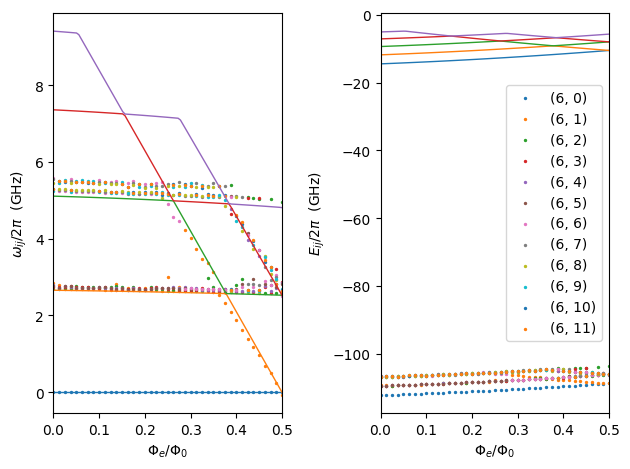

In [8]:
# compare with effective single mode

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from effective_flux import Fluxonium    # effective_flux.py

phi_ext_range = np.linspace(0, np.pi / 2, 100)  # the sweep range of phi_ext
N_ESM = 5  # the number of lines in the spectrum
N = energies.shape[1]  # the number of lines in the spectrum (n_excited)
energies_ESM = np.zeros((len(phi_ext_range), N))
for n, var in enumerate(tqdm(phi_ext_range)):
    fluxonium = Fluxonium(EJ=7.5, EC=0.48, EL=1.27, phi_ext=var,
                          N_truncation=20, basis='flux',
                          theta_begin=-2, theta_end=2)
    energies_ESM[n, :] = fluxonium.eigenValues(N)
# compare directly
plt.figure()
# Plot frequency (\omega_01, \omega_02, ..., \omega_0n)
plt.subplot(121)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ \omega_{ij}/2\pi$  (GHz)')
for j in range(N):
    if j < N_ESM:
        plt.plot(phi_ext_range / np.pi, (energies_ESM[:, j] - energies_ESM[:, 0]), linewidth='1')
    plt.scatter(phi_e_range, (energies[:, j] - energies[:, 0]) * n_j, label=(n_j, j), s=2)
# Plot energy (E_0, E_1, ..., E_n)
plt.subplot(122)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ E_{ij}/2\pi$  (GHz)')
for j in range(N):
    if j < N_ESM:
        plt.plot(phi_ext_range / np.pi, energies_ESM[:, j], linewidth='1')
    plt.scatter(phi_e_range, energies[:, j] * n_j, label=(n_j, j), s=2)
plt.tight_layout()
plt.legend()

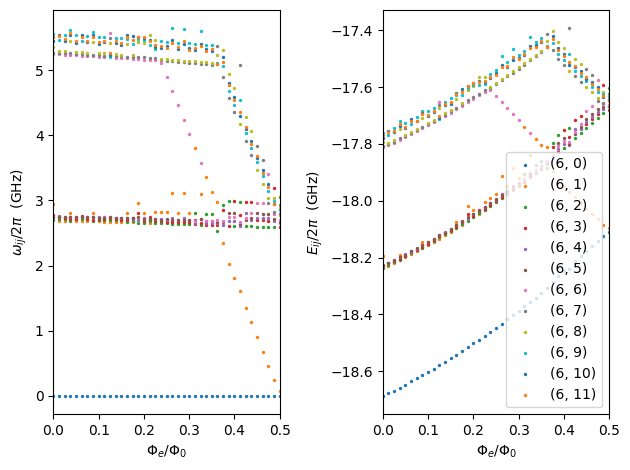

In [3]:
from matplotlib import pyplot as plt
plt.figure()
# Plot frequency
plt.subplot(121)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ \omega_{ij}/2\pi$  (GHz)')
for j in range(N):
    plt.scatter(phi_e_range, (energies[:, j] - energies[:, 0]) * n_j, label=(n_j, j), s=2)
# Plot energy
plt.subplot(122)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ E_{ij}/2\pi$  (GHz)')
for j in range(N):
    plt.scatter(phi_e_range, energies[:, j], label=(n_j, j), s=2)
plt.tight_layout()
plt.legend()

results:

n_j = 6, n_excited = 12, Ds = 12, N_Lanczos = 6, basis='flux'

phi_ext_range = np.linspace(0, np.pi / 2, 41) 

usingLanczos=True, Eng_criterion=0.01

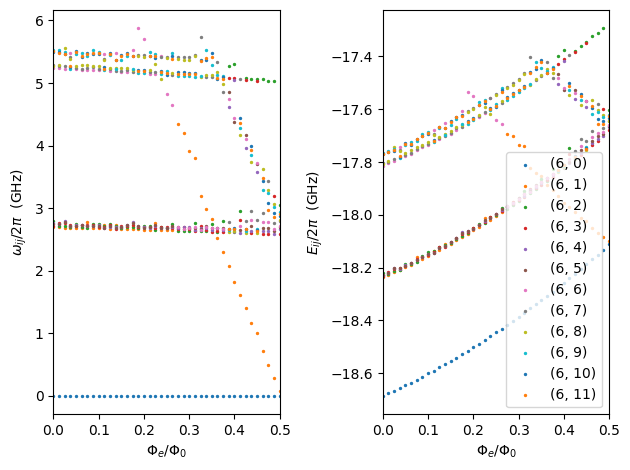

n_j = 6, n_excited = 12, Ds = 12, N_Lanczos = 4, basis='flux'

phi_ext_range = np.linspace(0, np.pi / 2, 41) 

usingLanczos=True, Eng_criterion=0.01

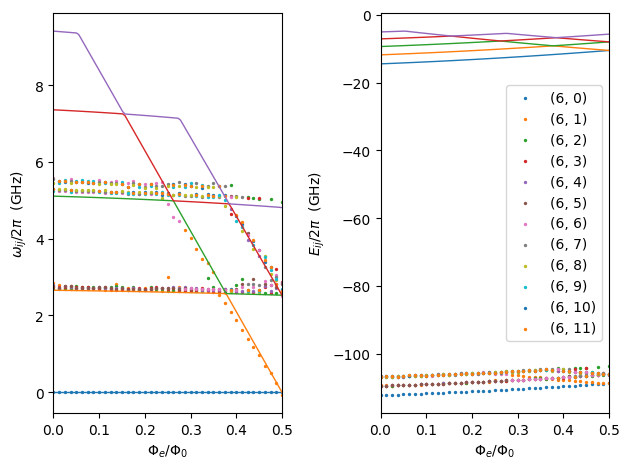

Fig.6 multi-targeted DMRG result, legends are (n_j, n_excitation), lines are effective single mode results

similar to Effective Single Mode result but higher excitations are difficult to calculate

##### Use small n_j = 3

In [ ]:
from flux import Flux
import numpy as np
from tqdm import tqdm
n_j = 3
n_excited = 12
phi_ext_range = np.linspace(0, np.pi / 2, 41)  # the sweep range of phi_ext
energies = np.zeros((len(phi_ext_range), n_excited))
for n, var in enumerate(tqdm(phi_ext_range)):
    f = Flux(N_J=n_j, N_excited=n_excited, Ds=12, N_Lanczos=6, basis='flux')
    f.set_phiExt(var)
    energies[n] = np.array(f.optimizeT(usingLanczos=True, Eng_criterion=0.01, N_criterion=12, Quiet=False))
N = energies.shape[1]  # the number of lines in the spectrum (n_excited)
# Plotting the energy spectrum
energies = energies[::-1, :]
phi_e_range = phi_ext_range / np.pi

100%|██████████| 41/41 [10:34<00:00, 15.49s/it]

N_J=3, N_excited=12, Ds=12, N_Lanczos=6, basis='flux', Eng_criterion=0.01, N_criterion=12

Compare directly with effective single mode:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from effective_flux import Fluxonium    # effective_flux.py

phi_ext_range = np.linspace(0, np.pi / 2, 100)  # the sweep range of phi_ext
N_ESM = 5  # the number of lines in the spectrum
N = energies.shape[1]  # the number of lines in the spectrum (n_excited)
energies_ESM = np.zeros((len(phi_ext_range), N))
for n, var in enumerate(tqdm(phi_ext_range)):
    fluxonium = Fluxonium(EJ=7.5, EC=0.48, EL=1.27, phi_ext=var,
                          N_truncation=20, basis='flux',
                          theta_begin=-2, theta_end=2)
    energies_ESM[n, :] = fluxonium.eigenValues(N)
# compare directly
plt.figure()
# Plot frequency (\omega_01, \omega_02, ..., \omega_0n)
plt.subplot(121)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ \omega_{ij}/2\pi$  (GHz)')
for j in range(N):
    if j < N_ESM:
        plt.plot(phi_ext_range / np.pi, (energies_ESM[:, j] - energies_ESM[:, 0]), linewidth='1')
    plt.scatter(phi_e_range, (energies[:, j] - energies[:, 0]) * n_j, label=(n_j, j), s=2)
# Plot energy (E_0, E_1, ..., E_n)
plt.subplot(122)
plt.xlim([phi_e_range[0], phi_e_range[-1]])
plt.xlabel(r'$\Phi_e /\Phi_0$')
plt.ylabel(r'$ E_{ij}/2\pi$  (GHz)')
for j in range(N):
    if j < N_ESM:
        plt.plot(phi_ext_range / np.pi, energies_ESM[:, j], linewidth='1')
    plt.scatter(phi_e_range, energies[:, j] * n_j, label=(n_j, j), s=2)
plt.tight_layout()
plt.legend()

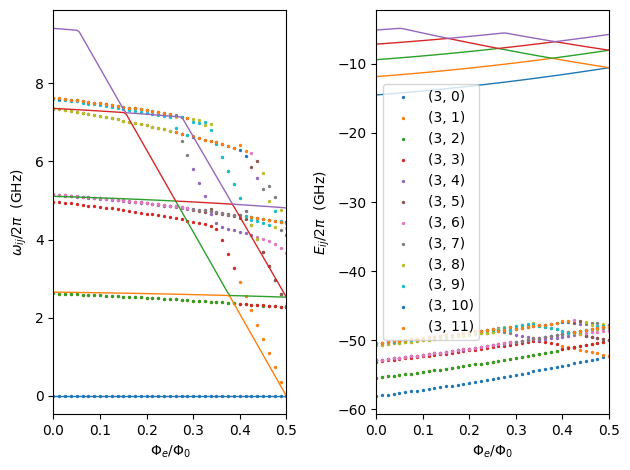

Fig.7 N_j = 3, lines are effective single mode result, dots are DMRG result, for small n_j low excitations not degenerate

#### On charge basis,

100%|██████████| 41/41 [03:04<00:00,  4.50s/it]

n_j = 6, n_excited = 6, Ds = 4, N_Lanczos = 4, basis='charge'

phi_ext_range = np.linspace(0, np.pi, 41) 

usingLanczos=True, Eng_criterion=0.02

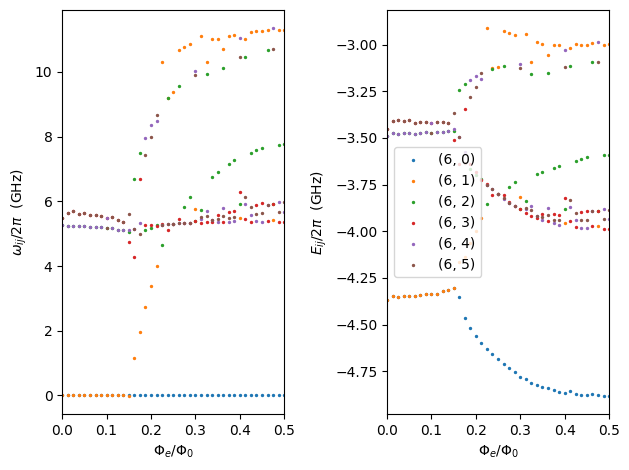

Fig.8 On charge basis we got different result, may because n_j is small, and using the first difference approximation to represent $\hat{\phi}$ is inaccurate.

## Possible improvement

Calculate all low excitations in block Lanczos is expensive, most of them should be abandoned according to degeneracy.

## References

1. Agustin, D. P., Baker, T. E., Foley, A., Sénéchal, D., & Alexandre, B. (2021). Efficient modeling of superconducting quantum circuits with tensor networks. *NPJ Quantum Information,* 7(1).
2. Baker, T. E., Foley, A., & Sénéchal, D. (2021). Direct solution of multiple excitations in a matrix product state with block Lanczos. *arXiv preprint arXiv:2109.08181.*
3. Baker, T. E., & Thompson, M. P. (2021). Build your own tensor network library: DMRjulia I. Basic library for the density matrix renormalization group. *arXiv preprint arXiv:2109.03120.*
4. Van Damme, M., Vanhove, R., Haegeman, J., Verstraete, F., & Vanderstraeten, L. (2021). Efficient matrix product state methods for extracting spectral information on rings and cylinders. *Physical Review B, 104(11), 115142.*